In [1]:
#Importation
import pickle
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import sklearn as sk
from sklearn import tree
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import matplotlib.pyplot as plt
from textblob import TextBlob
from statistics import mean
from math import ceil
from collections import Counter
warnings.filterwarnings('ignore')

In [2]:
# On ramene les données du prétraitement du dataframe
df2 = pd.read_pickle("./PICKLE/df_stat_commentaires.pkl")
df2

,nombre_commentaires,Longueur moyenne commentaire,Reussite,polarite,subjectivite
0,-0.755824,-0.328797,False,0.000000,0.000000
1,0.333062,-0.468411,True,0.100000,0.100000
2,1.966390,1.752941,True,0.062500,0.062500
3,-0.755824,-0.627969,True,0.133333,0.158333
4,-0.755824,-0.877279,True,0.166667,0.166667
...,...,...,...,...,...
4183,1.966390,-0.359961,True,0.000000,0.000000
4184,-0.755824,-0.665366,True,0.166667,0.166667
4185,-0.755824,-0.627969,True,0.166667,0.166667
4186,0.333062,-0.722707,True,0.100000,0.100000


### Séparation des dataset d'évaluation et d'apprentissage

In [23]:
def creation_test_train(dataframe,label):
    train_df = dataframe.sample(frac=0.8)
    test_df = dataframe.drop(train_df.index)

    train_df_Y = train_df[label]
    test_df_Y = test_df[label]

    train_df_X = train_df.drop(label,axis=1)
    test_df_X = test_df.drop(label,axis=1)
    
    return train_df_X,train_df_Y,test_df_X,test_df_Y

In [24]:
train_df_X,train_df_Y,test_df_X,test_df_Y = creation_test_train(df2,"Reussite")
train_df_X.dtypes

nombre_commentaires             float64
Longueur moyenne commentaire    float64
polarite                        float64
subjectivite                    float64
dtype: object

### Premier arbre de décision

In [5]:
tree_classifier = DecisionTreeClassifier(max_depth=5,
random_state=42)
tree_classifier.fit(train_df_X, train_df_Y)

DecisionTreeClassifier(max_depth=5, random_state=42)

In [6]:
y_pred = tree_classifier.predict(test_df_X)

### Statistiques du modèle

In [7]:
sk.metrics.multilabel_confusion_matrix(test_df_Y,y_pred)

array([[[703,  20],
        [ 40,  75]],

       [[ 75,  40],
        [ 20, 703]]], dtype=int64)

In [8]:
def stat_modele(true,pred,arrondi=5,affichage=False):
    accuracy = round(sk.metrics.accuracy_score(true,pred),arrondi)*100
    rappel = round(sk.metrics.recall_score(true,pred),arrondi)*100
    precision = round(sk.metrics.precision_score(true,pred),arrondi)*100
    specificity = round(sk.metrics.recall_score(true,pred,pos_label=0),arrondi)*100
    vpn = round(sk.metrics.precision_score(true,pred,pos_label=0),arrondi)*100
    if affichage :
        print("Accuracy : proportion de prédictions correctes (VP + VN /(VP+VN+FN+FP)) : " + str(accuracy) + "%")
        print("Rappel : proportion de réussites correctement prédites sur l'ensemble des réussites (VP/(VP+FN)) : " + str(rappel) + "%")
        print("Précision :  proportion de véritables réussites parmi les réussites prédites (VP/(VP+FP)) : " + str(precision) + "%")
        print("Spécificité : proportion d'échecs correctement prédits sur l'ensemble des échecs (VN/(VN+FP)) : "+str(specificity) + "%")
        print("Valeur prédictive négative: proportion de véritables échecs parmi les échecs prédits (VN/(VN+FN)) : " + str(vpn) + "%")
   
    return accuracy,rappel,precision,specificity,vpn

In [9]:
stat_modele(test_df_Y,y_pred,affichage=True)

Accuracy : proportion de prédictions correctes (VP + VN /(VP+VN+FN+FP)) : 92.84%
Rappel : proportion de réussites correctement prédites sur l'ensemble des réussites (VP/(VP+FN)) : 97.234%
Précision :  proportion de véritables réussites parmi les réussites prédites (VP/(VP+FP)) : 94.616%
Spécificité : proportion d'échecs correctement prédits sur l'ensemble des échecs (VN/(VN+FP)) : 65.217%
Valeur prédictive négative: proportion de véritables échecs parmi les échecs prédits (VN/(VN+FN)) : 78.947%


(92.84, 97.234, 94.616, 65.217, 78.947)

Pour un premier essai c'est pas mal : quand le modèle prédit un échec il ne se trompe pas dans 67.5% des cas, un échec sera prédit comme tel dans 76% des cas et les réussites prédites comme telles sont des réussites dans 96.7% des cas !

L'objectif est de faire un modèle améliorant la valeur prédictive négative et la spécificité.

### Rafinnage 
Finetune des hyperparamètres

In [10]:
def BestHyperparameters_vpn(trainX,trainY,testX,testY,min_example,depth):
    best_vpn = 0
    best_min_example = 0
    best_depth = 0
    best_criterion = ""
    #On va tester toutes les combinaisons possibles :
    for criterion in ["gini","entropy"]:
        for example in min_example:
            for profondeur in depth:
                #On créer l'arbre
                arbre = DecisionTreeClassifier(criterion=criterion,min_samples_leaf=example,max_depth=profondeur)
                arbre.fit(trainX, trainY)
                #On calcule la prédiction et la vpn associée
                predictionY = arbre.predict(testX)
                vpn = round(sk.metrics.precision_score(testY,predictionY,pos_label=0),5)*100
                #On compare
                if vpn>best_vpn :
                    best_vpn = vpn
                    best_min_example = example
                    best_depth = profondeur
                    best_criterion= criterion
                
    return (best_vpn,best_min_example,best_depth,best_criterion)

In [11]:
def BestHyperparameters_spe(trainX,trainY,testX,testY,min_example,depth):
    best_spe = 0
    best_min_example = 0
    best_depth = 0
    best_criterion = ""
    #On va tester toutes les combinaisons possibles :
    for criterion in ["gini","entropy"]:
        for example in min_example:
            for profondeur in depth:
                #On créer l'arbre
                arbre = DecisionTreeClassifier(criterion=criterion,min_samples_leaf=example,max_depth=profondeur)
                arbre.fit(trainX, trainY)
                #On calcule la prédiction et la specificite associee
                predictionY = arbre.predict(testX)
                spe = round(sk.metrics.recall_score(testY,predictionY,pos_label=0),5)*100
                #On compare
                if spe>best_spe :
                    best_spe = spe
                    best_min_example = example
                    best_depth = profondeur
                    best_criterion= criterion
                
    return (best_spe,best_min_example,best_depth,best_criterion)

In [12]:
#Fonction permettant de trouver les meilleurs hyperparametres en refaisant les dataset d'entrainement de test plusieurs fois et en gardant la moyenne
def Finetune_vpn(nombre_essai,min_example,depth):
    l_vpn = []
    l_best_min_example = []
    l_best_depth = []
    l_best_criterion = []
    
    for i in range (0,nombre_essai) :
        if i%10==0 :
            print(i)
        trainX,trainY,testX,testY = creation_test_train(df2,"Reussite")
        best_vpn,best_min_example,best_depth,best_criterion = BestHyperparameters_vpn(trainX,trainY,testX,testY,min_example,depth)
        l_vpn.append(best_vpn)
        l_best_min_example.append(best_min_example)
        l_best_depth.append(best_depth)
        l_best_criterion.append(best_criterion)
    return mean(l_vpn),Counter(l_best_min_example).most_common(1)[0][0],Counter(l_best_depth).most_common(1)[0][0],Counter(l_best_criterion).most_common(1)[0][0]
    

In [13]:
def Finetune_spe(nombre_essai,min_example,depth):
    l_spe = []
    l_best_min_example = []
    l_best_depth = []
    l_best_criterion = []
    
    for i in range (0,nombre_essai) :
        if i%10==0 :
            print(i)
        trainX,trainY,testX,testY = creation_test_train(df2,"Reussite")
        best_spe,best_min_example,best_depth,best_criterion = BestHyperparameters_spe(trainX,trainY,testX,testY,min_example,depth)
        l_spe.append(best_spe)
        l_best_min_example.append(best_min_example)
        l_best_depth.append(best_depth)
        l_best_criterion.append(best_criterion)
    return mean(l_spe),Counter(l_best_min_example).most_common(1)[0][0],Counter(l_best_depth).most_common(1)[0][0],Counter(l_best_criterion).most_common(1)[0][0]
    

In [14]:
Finetune_vpn(250,[2,3,4,5],[2,3,4,5,6])

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240


(73.191128, 2, 4, 'gini')

In [15]:
Finetune_spe(250,[2,3,4,5],[2,3,4,5,6])

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240


(79.511124, 2, 6, 'gini')

Pour les deux mesures les meilleurs paramètres sont min_example = 2, max_depth = 4 et criterion = "gini".
On va les utiliser pour la visualisation de l'arbre.

In [16]:
def afficherArbreDecision(class_names,feature_names,arbre):
    fig, ax = plt.subplots(figsize=(12, 12))
    tree.plot_tree(arbre, feature_names=feature_names, class_names=class_names, filled=True, ax=ax)
    plt.show()

In [25]:
arbre = DecisionTreeClassifier(criterion="gini",min_samples_leaf=2,max_depth=4)
arbre.fit(train_df_X, train_df_Y)
class_names = ["Réussite","Echec"]
features_names = ["nombre_commentaires","Longueur moyenne commentaire", "polarite","subjectivite"]


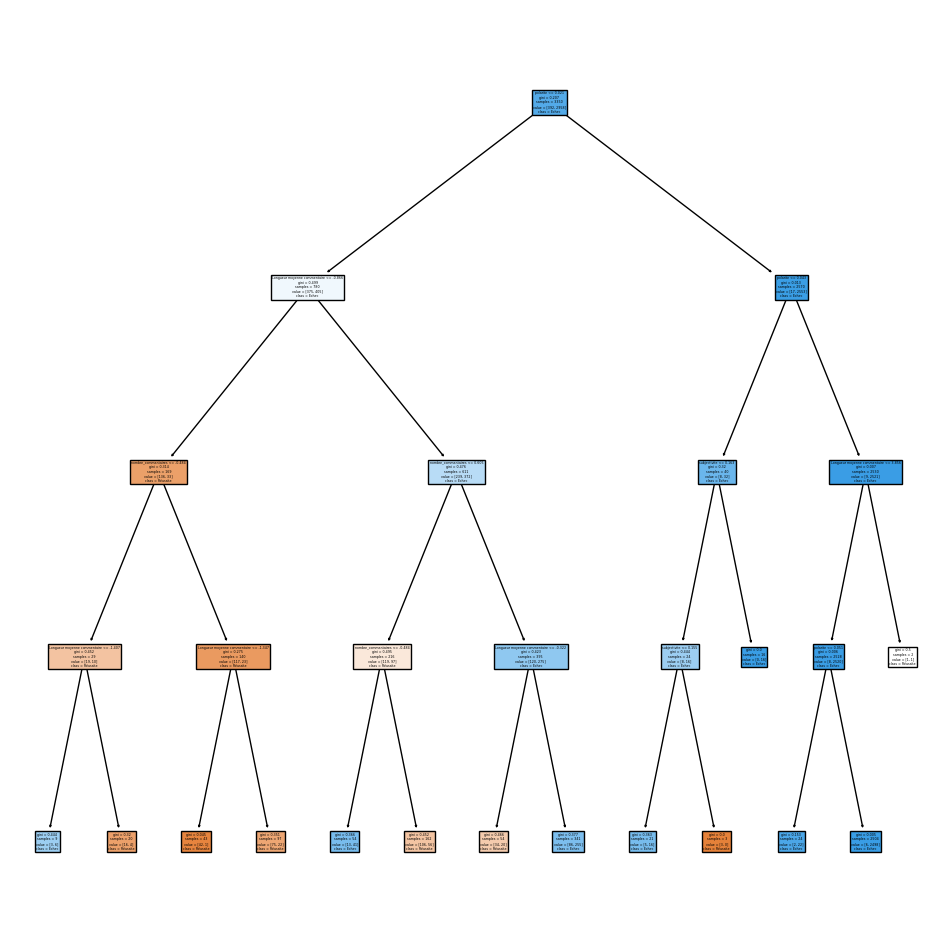

In [26]:
afficherArbreDecision(class_names,features_names,arbre)

In [27]:
y_pred = arbre.predict(test_df_X)

In [28]:
stat_modele(test_df_Y,y_pred,affichage=True)

Accuracy : proportion de prédictions correctes (VP + VN /(VP+VN+FN+FP)) : 93.31700000000001%
Rappel : proportion de réussites correctement prédites sur l'ensemble des réussites (VP/(VP+FN)) : 96.429%
Précision :  proportion de véritables réussites parmi les réussites prédites (VP/(VP+FP)) : 95.902%
Spécificité : proportion d'échecs correctement prédits sur l'ensemble des échecs (VN/(VN+FP)) : 72.727%
Valeur prédictive négative: proportion de véritables échecs parmi les échecs prédits (VN/(VN+FN)) : 75.472%


(93.31700000000001, 96.429, 95.902, 72.727, 75.472)

In [ ]:
-> vpn à maximiser